
# Predicting wildfire occurrence in Alaska

### Hana Matsumoto

---

## Import libraries

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rasterio
import shapely

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Wildfire dataset

### Import and inspect data

In [30]:
# Import dataset
WF_df = pd.read_csv('data/Wildland_Fire_Incident_Locations.csv')

# Display
WF_df.head()

,X,Y,OBJECTID,SourceOID,ABCDMisc,ADSPermissionState,ContainmentDateTime,ControlDateTime,CreatedBySystem,IncidentSize,...,EstimatedFinalCost,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,IsCpxChild,CpxName,CpxID,SourceGlobalID,GlobalID
0,-144.250029,67.616672,57,1398497,NaN,DEFAULT,NaN,NaN,firebeans,0.1,...,NaN,NaN,NaN,2016/06/25 20:34:48+00,2016/08/08 23:36:25+00,0,NaN,NaN,{A22F62A6-32FD-4690-B843-D1F7B76D5BB6},{C2E620F8-6951-42C3-8AA9-AB1334F2F1D8}
1,-149.400029,67.466671,147,1403604,NaN,DEFAULT,NaN,NaN,firebeans,0.1,...,NaN,NaN,NaN,2016/06/27 00:30:28+00,2016/07/22 19:11:04+00,0,NaN,NaN,{6A2AC1E4-64E5-4E8F-9769-6E5981CE387C},{124CC6EF-6D92-4E8A-905F-0134588D0638}
2,-149.729423,60.480312,486,23828864,NaN,DEFAULT,NaN,NaN,wildcad,18.0,...,NaN,NaN,NaN,2022/04/12 16:14:36+00,2022/05/06 00:05:46+00,0,NaN,NaN,{FEF701E4-8657-41E0-BF21-0B4C6A58D5B9},{DC04511E-03BA-44F1-976D-F634DF08A48D}
3,-146.533355,63.766672,786,1400174,NaN,DEFAULT,NaN,NaN,firebeans,0.1,...,NaN,NaN,NaN,2016/06/26 00:34:37+00,2016/08/08 23:36:12+00,0,NaN,NaN,{56B9C519-12CC-45C6-B9BC-51140189185D},{5CFF103B-E3D4-43DA-B2A7-576E60ECD509}
4,-149.567523,60.567692,1278,22050793,NaN,DEFAULT,NaN,NaN,wildcad,22.0,...,NaN,NaN,NaN,2021/10/19 23:52:21+00,2021/10/29 00:30:41+00,0,NaN,NaN,{FF2E4A79-055D-44A2-9B3B-B197C8ABC755},{FA9F8F49-3EEF-4201-B2AE-5EC6C411B1DA}


In [10]:
# Checking out dataset
WF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 96 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   X                                4624 non-null   float64
 1   Y                                4624 non-null   float64
 2   OBJECTID                         4624 non-null   int64  
 3   SourceOID                        4624 non-null   int64  
 4   ABCDMisc                         5 non-null      object 
 5   ADSPermissionState               4624 non-null   object 
 6   ContainmentDateTime              4335 non-null   object 
 7   ControlDateTime                  4306 non-null   object 
 8   CreatedBySystem                  4624 non-null   object 
 9   IncidentSize                     4558 non-null   float64
 10  DiscoveryAcres                   4500 non-null   float64
 11  DispatchCenterID                 4531 non-null   object 
 12  EstimatedCostToDate 

In [11]:
# Statistics of numeric columns
WF_df.describe()

,X,Y,OBJECTID,SourceOID,IncidentSize,DiscoveryAcres,EstimatedCostToDate,FinalAcres,FinalFireReportApprovedByTitle,FinalFireReportApprovedByUnit,...,IsTrespass,IsUnifiedCommand,PercentContained,PercentPerimeterToBeContained,POOFips,POOJurisdictionalUnitParentUnit,POOLegalDescSection,TotalIncidentPersonnel,EstimatedFinalCost,IsCpxChild
count,4624.000000,4624.000000,4624.000000,4.624000e+03,4558.000000,4500.000000,1.508000e+03,2867.000000,0.0,0.0,...,1813.000000,357.0,973.000000,577.000000,4624.000000,0.0,396.000000,559.000000,1.980000e+02,4624.000000
mean,-150.163262,62.995864,184037.604455,7.701372e+06,3740.540667,36.096378,3.391441e+05,1503.977168,NaN,NaN,...,0.014341,0.0,37.671120,34.913345,2182.163927,NaN,18.234848,14.121646,2.251111e+06,0.015138
std,6.009096,2.416518,62613.516597,8.340110e+06,25040.335697,353.222213,1.896804e+06,11592.905652,NaN,NaN,...,0.118924,0.0,47.306186,47.284446,81.271227,NaN,10.384648,21.203728,6.667362e+06,0.122117
min,-176.645294,51.954443,57.000000,5.009160e+05,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,2013.000000,NaN,1.000000,0.000000,0.000000e+00,0.000000
25%,-152.975194,61.451540,132879.250000,1.134369e+06,0.100000,0.100000,0.000000e+00,0.100000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,2122.000000,NaN,9.000000,0.000000,5.000000e+04,0.000000
50%,-149.590186,63.167386,185308.500000,4.442968e+06,0.400000,0.100000,1.102500e+03,0.100000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,2170.000000,NaN,18.000000,7.000000,2.500000e+05,0.000000
75%,-146.822326,64.829229,236837.750000,9.642080e+06,49.925000,1.000000,4.057103e+04,2.000000,NaN,NaN,...,0.000000,0.0,100.000000,100.000000,2261.000000,NaN,27.000000,21.000000,1.000000e+06,0.000000
max,-131.607797,70.330801,298395.000000,2.387793e+07,865625.000000,15160.000000,4.810109e+07,308922.700000,NaN,NaN,...,1.000000,0.0,100.000000,100.000000,2290.000000,NaN,36.000000,188.000000,5.500000e+07,1.000000


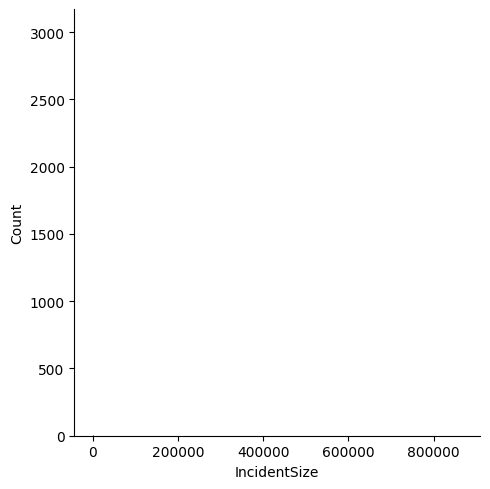

In [93]:
sns.displot(WF_df['IncidentSize'])

### Clean dataset

#### *Removing unwanted columns and fixing missing values*

In [31]:
# Selecting only columns of interest
# Too many columns to use df.drop()
WF_df_drop = WF_df[['X', 'Y', 'OBJECTID', 'IncidentSize', 'FireBehaviorGeneral', 
               'FireCause', 'FireDiscoveryDateTime', 'POOCounty', 
               'POOFips', 'POOLandownerCategory', 'PrimaryFuelModel']]

In [7]:
# Check for null values
WF_df_drop.isnull().sum()

X                           0
Y                           0
OBJECTID                    0
IncidentSize               66
FireBehaviorGeneral      1814
FireCause                  52
FireDiscoveryDateTime       0
POOCounty                   0
POOFips                     0
POOLandownerCategory      189
PrimaryFuelModel         2018
dtype: int64

In [37]:
# Drop columns with too many nulls values
# Won't be useful for predicting
WF_df_drop = WF_df_drop.drop(['FireBehaviorGeneral', 'PrimaryFuelModel'], axis=1)
#WF_df_drop = WF_df[['X', 'Y', 'OBJECTID', 'IncidentSize', 
#               'FireCause', 'FireDiscoveryDateTime', 
#               'POOCounty', 'POOFips', 'POOLandownerCategory']]

In [38]:
# Check on missing values
WF_df_drop.isnull().sum()

X                          0
Y                          0
OBJECTID                   0
IncidentSize              66
FireCause                 52
FireDiscoveryDateTime      0
POOCounty                  0
POOFips                    0
POOLandownerCategory     189
dtype: int64


#### *Selecting incidents with fire of a certain size*

In this case, I am interested in fires 10 units (presumably acres) and larger


In [64]:
# Locate fires
WF_df_size = WF_df_drop.loc[WF_df_drop['IncidentSize'] >= 10]

In [65]:
# How many fire incidents are left?
WF_df_size.shape

(1447, 9)

In [66]:
# Check for nulls
WF_df_size.isnull().sum()

X                         0
Y                         0
OBJECTID                  0
IncidentSize              0
FireCause                 9
FireDiscoveryDateTime     0
POOCounty                 0
POOFips                   0
POOLandownerCategory     93
dtype: int64

In [68]:
# I am choosing to just drop all rows (total of 102, should leave me with 1345 fires) with missing values
WF_df_size = WF_df_size.dropna(axis=0)
WF_df_size.shape

(1345, 9)

In [69]:
# Check on statistics again
WF_df_size.describe()

,X,Y,OBJECTID,IncidentSize,POOFips
count,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000
mean,-153.030198,64.029477,185894.981413,10319.396461,2208.157621
std,6.389534,2.258615,60639.265943,29898.097458,93.954478
min,-176.645294,51.954443,486.000000,10.000000,2013.000000
25%,-157.856585,62.390800,135871.000000,65.200000,2122.000000
50%,-153.689529,64.261100,191801.000000,467.200000,2240.000000
75%,-147.658946,65.595221,236263.000000,5083.500000,2290.000000
max,-134.840946,69.754439,291584.000000,312918.200000,2290.000000



#### *Time feature*

Need to convert date column and make seperate year, month, day columns


In [71]:
# Create copy of df
WF_df_time = WF_df_size.copy()

# Converting time
WF_df_time['FireDiscoveryDateTime'] = pd.to_datetime(WF_df_time["FireDiscoveryDateTime"]).dt.date
WF_df_time

,X,Y,OBJECTID,IncidentSize,FireCause,FireDiscoveryDateTime,POOCounty,POOFips,POOLandownerCategory
2,-149.729423,60.480312,486,18.0,Undetermined,2022-03-16,Kenai Peninsula,2122,USFS
4,-149.567523,60.567692,1278,22.0,Undetermined,2021-10-19,Kenai Peninsula,2122,USFS
5,-151.167666,64.832403,2575,212504.4,Undetermined,2022-06-26,Yukon-Koyukuk,2290,State
8,-176.645294,51.954443,5090,919.6,Human,2022-05-08,Aleutians West,2016,DOD
9,-149.576223,60.560982,5850,40.0,Undetermined,2020-11-18,Kenai Peninsula,2122,USFS
...,...,...,...,...,...,...,...,...,...
4603,-151.764697,65.909831,290626,11305.6,Natural,2018-06-06,Yukon-Koyukuk,2290,BLM
4609,-159.883025,64.750000,291108,200.0,Natural,2014-08-12,Nome,2180,Tribal
4611,-153.766692,63.566668,291217,1682.0,Natural,2015-06-26,Yukon-Koyukuk,2290,State
4612,-155.412026,64.574500,291240,2695.0,Natural,2015-06-22,Yukon-Koyukuk,2290,Tribal


In [72]:
# Creating year, month, date columns
WF_df_time['year'] = pd.DatetimeIndex(WF_df_time['FireDiscoveryDateTime']).year
WF_df_time['month'] = pd.DatetimeIndex(WF_df_time['FireDiscoveryDateTime']).month
WF_df_time['day'] = pd.DatetimeIndex(WF_df_time['FireDiscoveryDateTime']).day
WF_df_time

,X,Y,OBJECTID,IncidentSize,FireCause,FireDiscoveryDateTime,POOCounty,POOFips,POOLandownerCategory,year,month,day
2,-149.729423,60.480312,486,18.0,Undetermined,2022-03-16,Kenai Peninsula,2122,USFS,2022,3,16
4,-149.567523,60.567692,1278,22.0,Undetermined,2021-10-19,Kenai Peninsula,2122,USFS,2021,10,19
5,-151.167666,64.832403,2575,212504.4,Undetermined,2022-06-26,Yukon-Koyukuk,2290,State,2022,6,26
8,-176.645294,51.954443,5090,919.6,Human,2022-05-08,Aleutians West,2016,DOD,2022,5,8
9,-149.576223,60.560982,5850,40.0,Undetermined,2020-11-18,Kenai Peninsula,2122,USFS,2020,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...
4603,-151.764697,65.909831,290626,11305.6,Natural,2018-06-06,Yukon-Koyukuk,2290,BLM,2018,6,6
4609,-159.883025,64.750000,291108,200.0,Natural,2014-08-12,Nome,2180,Tribal,2014,8,12
4611,-153.766692,63.566668,291217,1682.0,Natural,2015-06-26,Yukon-Koyukuk,2290,State,2015,6,26
4612,-155.412026,64.574500,291240,2695.0,Natural,2015-06-22,Yukon-Koyukuk,2290,Tribal,2015,6,22


In [73]:
# Drop FireDiscoveryDateTime
WF_df_time = WF_df_time.drop(['FireDiscoveryDateTime'], axis=1)
WF_df_time

,X,Y,OBJECTID,IncidentSize,FireCause,POOCounty,POOFips,POOLandownerCategory,year,month,day
2,-149.729423,60.480312,486,18.0,Undetermined,Kenai Peninsula,2122,USFS,2022,3,16
4,-149.567523,60.567692,1278,22.0,Undetermined,Kenai Peninsula,2122,USFS,2021,10,19
5,-151.167666,64.832403,2575,212504.4,Undetermined,Yukon-Koyukuk,2290,State,2022,6,26
8,-176.645294,51.954443,5090,919.6,Human,Aleutians West,2016,DOD,2022,5,8
9,-149.576223,60.560982,5850,40.0,Undetermined,Kenai Peninsula,2122,USFS,2020,11,18
...,...,...,...,...,...,...,...,...,...,...,...
4603,-151.764697,65.909831,290626,11305.6,Natural,Yukon-Koyukuk,2290,BLM,2018,6,6
4609,-159.883025,64.750000,291108,200.0,Natural,Nome,2180,Tribal,2014,8,12
4611,-153.766692,63.566668,291217,1682.0,Natural,Yukon-Koyukuk,2290,State,2015,6,26
4612,-155.412026,64.574500,291240,2695.0,Natural,Yukon-Koyukuk,2290,Tribal,2015,6,22



#### *Checking out unique values*


In [75]:
WF_df_time['FireCause'].unique()

array(['Undetermined', 'Human', 'Unknown', 'Natural'], dtype=object)

In [74]:
(WF_df_time['FireCause'] == 'Undetermined').sum()

32

In [76]:
(WF_df_time['FireCause'] == 'Unknown').sum()

13

In [77]:
WF_df_time['POOLandownerCategory'].unique()

array(['USFS', 'State', 'DOD', 'Private', 'ANCSA', 'USFWS', 'NPS', 'BLM',
       'Tribal', 'County', 'BIA', 'DOE'], dtype=object)

#### *Exploring data*

In [85]:
# Checking correlation
# Compute correlation matrix
corr_matrix = WF_df_time.corr()

# Display just house value correlations
corr_matrix["IncidentSize"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_4152\2148233967.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = WF_df_time.corr()


IncidentSize    1.000000
POOFips         0.109362
day             0.068864
year            0.026757
Y               0.021483
X              -0.001651
OBJECTID       -0.026862
month          -0.062542
Name: IncidentSize, dtype: float64

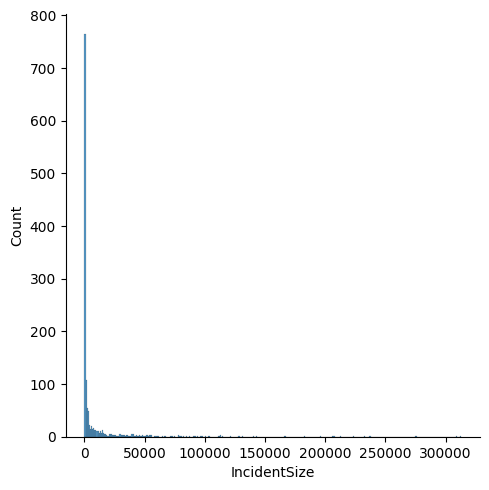

In [80]:
sns.displot(WF_df_time['IncidentSize'])

#### *Time to convert categorical features*

In [119]:
# cat_columns = WF_df[['FireBehaviorGeneral', 'FireCause', 'FireCauseGeneral', 
#                'POOCounty', 'POOLandownerCategory', 'PrimaryFuelModel']]
# pd.get_dummies(cat_columns, prefix=None, dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

# Copy the original data
features = WF_df_time.copy()

# Select the numeric columns
numeric_subset = WF_df_time.select_dtypes('number')

# Create columns with log of numeric columns
# for col in numeric_subset.columns:
#     # Skip the Energy Star Score column
#     if col == 'IncidentSize':
#         next
#     else:
#         numeric_subset['log_' + col] = np.log(numeric_subset[col])
#numeric_subset = WF_df_time[['FireCause', 'POOCounty', 'POOLandownerCategory']]
        
# Select the categorical columns
categorical_subset = WF_df_time[['FireCause', 'POOCounty', 'POOLandownerCategory']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

(1345, 45)

#### *Exploring data*

In [118]:
# Checking correlation
# Compute correlation matrix
corr_matrix = features.corr()

# Display just fire size correlations
corr_matrix["IncidentSize"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_4152\3579304825.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = features.corr()


IncidentSize                      1.000000
POOCounty_Yukon-Koyukuk           0.165045
FireCause_Undetermined            0.109592
POOFips                           0.109362
POOLandownerCategory_USFWS        0.089276
POOLandownerCategory_Tribal       0.074582
day                               0.068864
FireCause_Natural                 0.051951
POOCounty_Dillingham              0.029820
POOLandownerCategory_BLM          0.027444
POOCounty_Kusilvak                0.027088
year                              0.026757
Y                                 0.021483
POOCounty_Kenai Peninsula         0.013588
POOLandownerCategory_State        0.009276
X                                -0.001651
POOLandownerCategory_DOE         -0.008523
POOCounty_Bristol Bay            -0.011420
POOLandownerCategory_BIA         -0.012516
POOCounty_Aleutians West         -0.012666
POOCounty_Aleutians East         -0.013267
POOCounty_Juneau                 -0.013278
POOCounty_Kodiak Island          -0.013678
FireCause_U

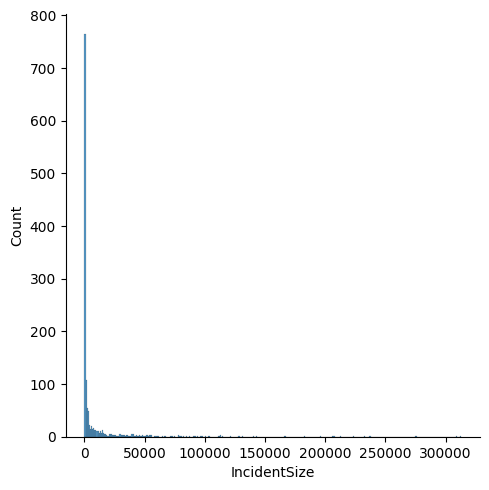

In [86]:
sns.displot(features['IncidentSize'])

<Axes: >

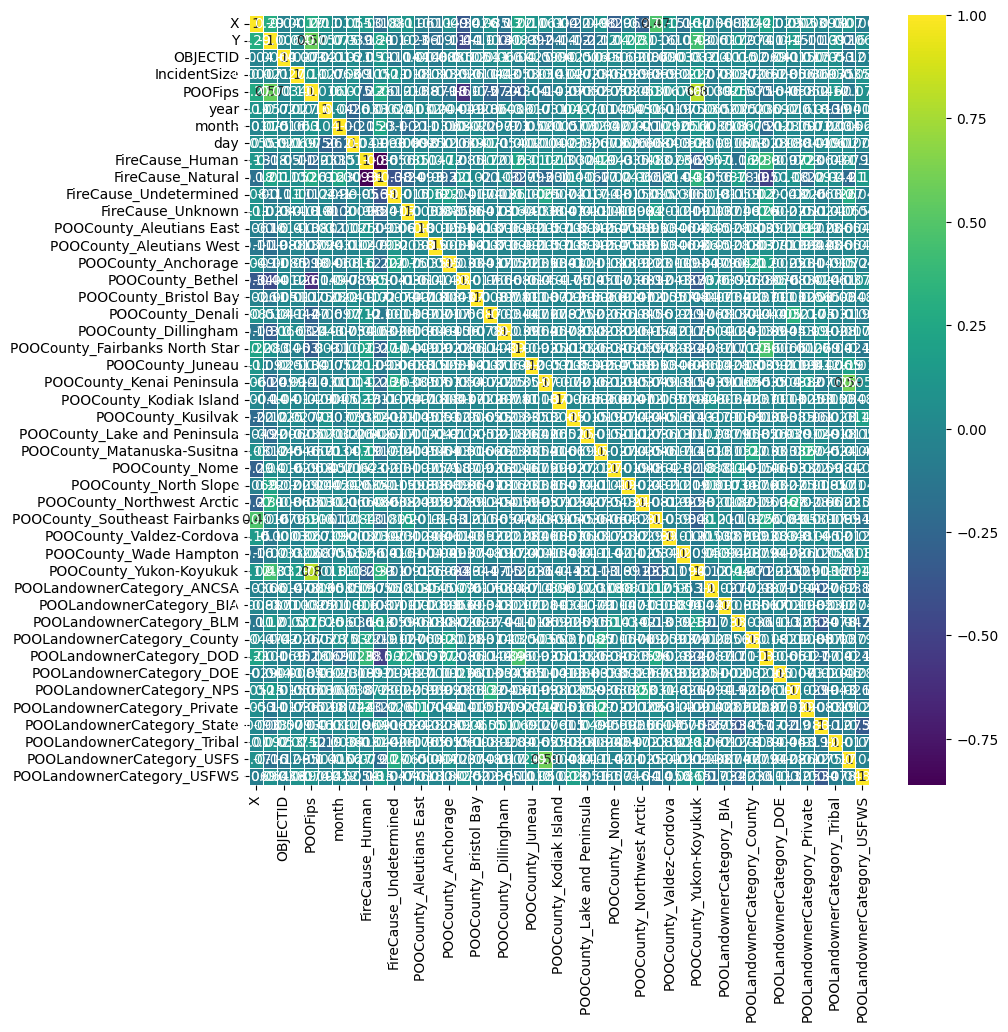

In [94]:
plt.figure(figsize=(10, 10))
sns.heatmap(features.corr(),annot=True,cmap='viridis',linewidths=.5)

#### *Convert df into gdf*

In [120]:
# Convert to features df to gdf
WF_gdf = gpd.GeoDataFrame(features, geometry=gpd.points_from_xy(features['X'], features['Y']))

## Forest type dataset

In [126]:
# Import master raster file
src = rasterio.open('data/alaska_foresttype_63360.img')
src

<open DatasetReader name='data/alaska_foresttype_63360.img' mode='r'>

In [127]:
# Find crs
src.crs

CRS.from_epsg(3338)

In [121]:
# Set gdf to the same crs
WF_gdf.set_crs(epsg = 3338, inplace=True)

,X,Y,OBJECTID,IncidentSize,POOFips,year,month,day,FireCause_Human,FireCause_Natural,...,POOLandownerCategory_County,POOLandownerCategory_DOD,POOLandownerCategory_DOE,POOLandownerCategory_NPS,POOLandownerCategory_Private,POOLandownerCategory_State,POOLandownerCategory_Tribal,POOLandownerCategory_USFS,POOLandownerCategory_USFWS,geometry
2,-149.729423,60.480312,486,18.0,2122,2022,3,16,0,0,...,0,0,0,0,0,0,0,1,0,POINT (-149.729 60.480)
4,-149.567523,60.567692,1278,22.0,2122,2021,10,19,0,0,...,0,0,0,0,0,0,0,1,0,POINT (-149.568 60.568)
5,-151.167666,64.832403,2575,212504.4,2290,2022,6,26,0,0,...,0,0,0,0,0,1,0,0,0,POINT (-151.168 64.832)
8,-176.645294,51.954443,5090,919.6,2016,2022,5,8,1,0,...,0,1,0,0,0,0,0,0,0,POINT (-176.645 51.954)
9,-149.576223,60.560982,5850,40.0,2122,2020,11,18,0,0,...,0,0,0,0,0,0,0,1,0,POINT (-149.576 60.561)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,-151.764697,65.909831,290626,11305.6,2290,2018,6,6,0,1,...,0,0,0,0,0,0,0,0,0,POINT (-151.765 65.910)
4609,-159.883025,64.750000,291108,200.0,2180,2014,8,12,0,1,...,0,0,0,0,0,0,1,0,0,POINT (-159.883 64.750)
4611,-153.766692,63.566668,291217,1682.0,2290,2015,6,26,0,1,...,0,0,0,0,0,1,0,0,0,POINT (-153.767 63.567)
4612,-155.412026,64.574500,291240,2695.0,2290,2015,6,22,0,1,...,0,0,0,0,0,0,1,0,0,POINT (-155.412 64.575)


In [130]:
WF_gdf.crs

<Derived Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meters)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [128]:
# Read raster
AK_forestype = src.read(1)

<Axes: >

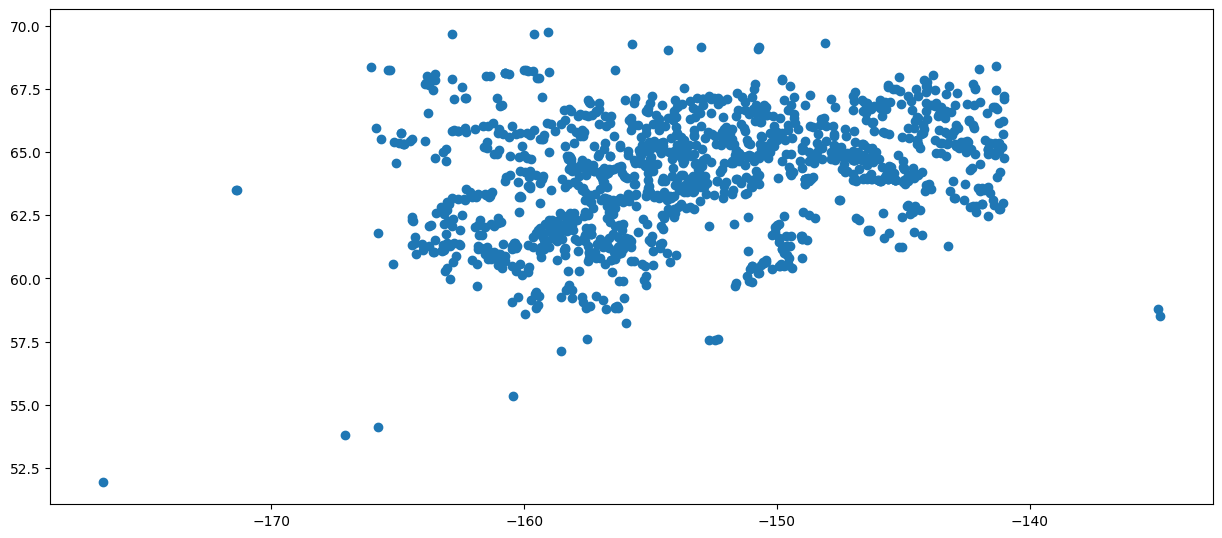

In [138]:
# Plot fires
fig, ax = plt.subplots(figsize = (15,15))
#im = ax.imshow(AK_forestype, cmap = 'tab20b')
WF_gdf.plot(ax=ax)

#ax = rasterplot.show(AK_forestype, extent=src_extent)
#WF_gdf.plot(ax=ax, color='pink', markersize = 10)


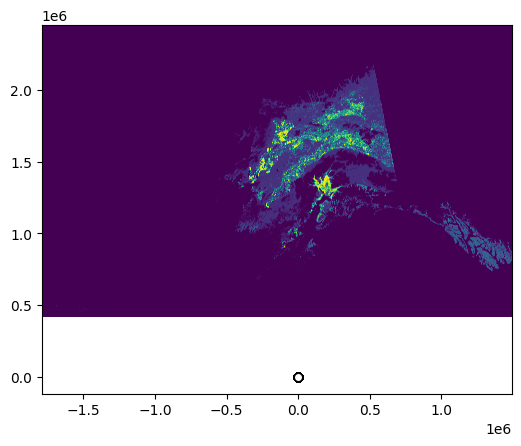

In [129]:
from rasterio import plot as rasterplot
from matplotlib import pyplot as plt

src_extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]

f, ax = plt.subplots()

# plot DEM
rasterplot.show(
    AK_forestype,  
    extent=src_extent,
    ax=ax,

)
# plot shapefiles
WF_gdf.plot(ax=ax, facecolor='w', edgecolor='k')
#plt.savefig('test.jpg')
plt.show()

In [139]:
# Read datasets
blackspruce = gpd.read_file('data/blackspruce.shp')
#mthemlock = gpd.read_file('data/mthemlock.shp')
paperbirch = gpd.read_file('data/paperbirch.shp')
whitespruce = gpd.read_file('data/whitespruceshp.shp')
aspen = gpd.read_file('data/aspen.shp')

In [140]:
aspen.crs

<Derived Projected CRS: PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["Nor ...>
Name: NAD_1983_Albers
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [142]:
# Reproject everything to NAD83 / Alaska Albers (EPSG:3338)
#gdf_utm = gdf_large.to_crs('EPSG:26936')
blackspruce_utm = blackspruce.to_crs('EPSG:3338')
#mthemlock_utm = mthemlock.to_crs('EPSG:3338')
paperbirch_utm = paperbirch.to_crs('EPSG:3338')
whitespruce_utm = whitespruce.to_crs('EPSG:3338')
aspen_utm = aspen.to_crs('EPSG:3338')

In [144]:
# Compute distance to black spruce
distance_to_blackspruce = []
for i in range(WF_gdf.shape[0]):
    distance_to_blackspruce.append(blackspruce_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_blackspruce'] = distance_to_blackspruce

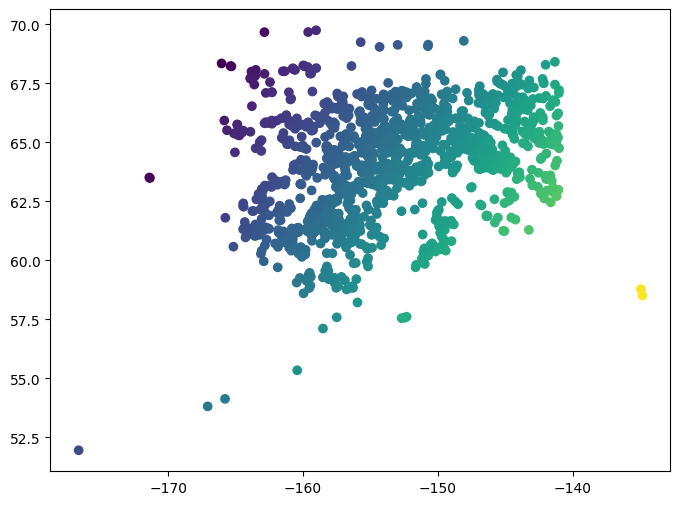

In [145]:
# Quickly check that it worked!
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(WF_gdf['geometry'].x, WF_gdf['geometry'].y, c=WF_gdf['distance_to_blackspruce'])

In [77]:
# # Compute distance to mthemlock
# distance_to_mthemlock = []
# for i in range(WF_gdf.shape[0]):
#     distance_to_mthemlock.append(mthemlock_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# # Add to DataFrame
# WF_gdf['distance_to_mthemlock'] = distance_to_mthemlock

In [146]:
# Compute distance to paper birch
distance_to_paperbirch = []
for i in range(WF_gdf.shape[0]):
    distance_to_paperbirch.append(paperbirch_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_paperbirch'] = distance_to_paperbirch

In [147]:
# Compute distance to white spruce
distance_to_whitespruce = []
for i in range(WF_gdf.shape[0]):
    distance_to_whitespruce.append(whitespruce_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_whitespruce'] = distance_to_whitespruce

In [148]:
# Compute distance to aspen
distance_to_aspen = []
for i in range(WF_gdf.shape[0]):
    distance_to_aspen.append(aspen_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_aspen'] = distance_to_aspen

In [149]:
# Compute correlation matrix
corr_matrix = WF_gdf.corr()

# Display just fire size correlations
corr_matrix["IncidentSize"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_4152\1184918758.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = WF_gdf.corr()


IncidentSize                      1.000000
POOCounty_Yukon-Koyukuk           0.165045
FireCause_Undetermined            0.109592
POOFips                           0.109362
POOLandownerCategory_USFWS        0.089276
POOLandownerCategory_Tribal       0.074582
day                               0.068864
FireCause_Natural                 0.051951
POOCounty_Dillingham              0.029820
POOLandownerCategory_BLM          0.027444
POOCounty_Kusilvak                0.027088
year                              0.026757
Y                                 0.021483
POOCounty_Kenai Peninsula         0.013588
POOLandownerCategory_State        0.009276
X                                -0.001651
POOLandownerCategory_DOE         -0.008523
POOCounty_Bristol Bay            -0.011420
distance_to_blackspruce          -0.011589
POOLandownerCategory_BIA         -0.012516
POOCounty_Aleutians West         -0.012666
POOCounty_Aleutians East         -0.013267
POOCounty_Juneau                 -0.013278
POOCounty_K

In [150]:
# Save csv so I don't need to run distance cells again
WF_gdf.to_csv('data/forest_type_fire.csv')

## Permafrost data

In [151]:
# Read dataset
permafrost = gpd.read_file('data/AK_permafrost.shp')

In [152]:
permafrost.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [153]:
permafrost_utm = permafrost.to_crs('EPSG:3338')

In [157]:
permafrost

,PERMAFROST,ACRES,HA,PFROST_2,geometry
0,21,436.18,176.52,Lowland and Upland Area underlain by thick per...,"POLYGON ((-156.46482 71.40968, -156.52155 71.3..."
1,21,108.10,43.75,Lowland and Upland Area underlain by thick per...,"POLYGON ((-156.46482 71.40968, -156.46011 71.4..."
2,21,31225820.51,12636641.25,Lowland and Upland Area underlain by thick per...,"POLYGON ((-156.63056 71.36657, -156.57207 71.3..."
3,21,134.52,54.44,Lowland and Upland Area underlain by thick per...,"POLYGON ((-155.68659 71.27256, -155.65526 71.2..."
4,21,537.29,217.43,Lowland and Upland Area underlain by thick per...,"POLYGON ((-155.54919 71.26037, -155.45319 71.2..."
...,...,...,...,...,...
808,31,49.88,20.19,Not defined,"POLYGON ((-168.41767 52.98705, -168.42739 52.9..."
809,31,144.21,58.36,Not defined,"POLYGON ((-168.48676 52.97032, -168.50257 52.9..."
810,31,1663.81,673.32,Not defined,"POLYGON ((-171.14383 52.55239, -171.19689 52.5..."
811,31,11044.77,4469.66,Not defined,"POLYGON ((-171.25378 52.43950, -171.30748 52.4..."


<Axes: >

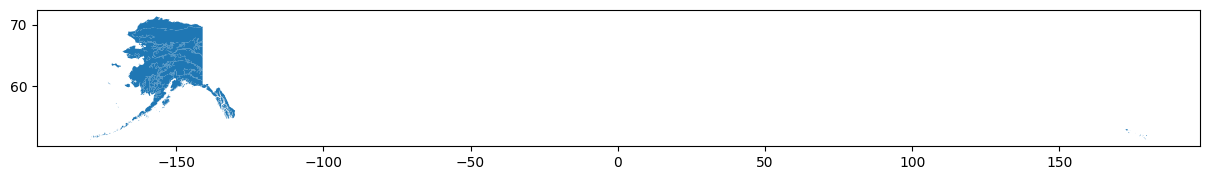

In [164]:
# Plot permafrost
fig, ax = plt.subplots(figsize = (15,15))
#im = ax.imshow(AK_forestype, cmap = 'tab20b')
permafrost.plot(ax=ax)

In [165]:
permafrost["geometry"].sort_values(ascending= False)

TypeError: geometries are not orderable

In [160]:
# Check out permafrost features
permafrost['PFROST_2'].unique()

array(['Lowland and Upland Area underlain by thick permafrost',
       'Mountainous Area underlain by continuous permafrost',
       'Lowland and Upland Area underlain by discontinuous permafrost',
       'Lowland and Upland Area underlain by moderately thick to thin permafrost',
       'Mountainous Area underlain by discontinuous permafrost',
       'Lowland and Upland Area underlain by numerous isolated masses of permafrost',
       'Lowland and Upland Area generally free of permafrost',
       'Not defined',
       'Lowland and Upland Area underlain by isolated masses of permafrost',
       'Mountainous Area underlain by isolated masses of permafrost'],
      dtype=object)

## Feature selection

## Feature scale

In [84]:
# Define feature list
feature_list =  ['X', 'Y', 'OBJECTID', 'IncidentSize', 'FireBehaviorGeneral', 
               'FireCause', 'POOCounty', 
               'POOFips', 'POOLandownerCategory', 'PrimaryFuelModel',
                'year', 'month', 'day', 'distance_to_mthemlock',
                'distance_to_blackspruce', 'distance_to_whitespruce', 'distance_to_paperbirch']

# Define features and labels 
X = gdf_utm[feature_list]
y = gdf_utm['IncidentSize']

In [85]:
# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_list)
df_scaled

,X,Y,OBJECTID,IncidentSize,FireBehaviorGeneral,FireCause,POOCounty,POOFips,POOLandownerCategory,PrimaryFuelModel,year,month,day,distance_to_mthemlock,distance_to_blackspruce,distance_to_whitespruce,distance_to_paperbirch
0,0.327355,0.317737,-3.069659,3.469015,-0.903542,-5.298978,-0.732657,0.804051,-1.095221,-1.242775,1.604925,-0.329659,1.288495,0.334940,0.334940,0.280573,-0.359606
1,0.960212,1.288633,-3.051278,1.354640,-0.903542,-3.436455,-0.732657,0.804051,-0.707504,-0.799078,0.465084,1.019530,0.533046,0.997310,0.997310,0.746588,-1.126732
2,-3.795576,-5.432394,-3.027441,-0.349133,-0.046964,-1.573932,-0.516518,-2.057516,-0.319786,-0.355381,1.604925,-1.678847,-0.977851,-3.956304,-3.956304,-2.877347,4.522082
3,-0.250906,0.201777,-2.747778,5.909261,0.809615,0.288591,-0.732657,0.804051,-0.707504,-1.242775,-1.054704,1.019530,-1.607392,-0.238182,-0.238182,-0.310667,0.185810
4,-0.278977,0.176326,-2.517702,2.167060,-0.903542,-5.298978,-0.732657,0.804051,0.067931,-1.242775,1.604925,-0.329659,1.540311,-0.266829,-0.266829,-0.335115,0.216285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,-0.923048,-0.814867,1.762958,-0.220977,-0.903542,0.288591,-0.732657,0.804051,0.843367,-0.799078,-0.674757,1.019530,-0.222403,-0.941063,-0.941063,-0.808621,0.997627
835,-0.397681,-0.037552,1.763159,-0.006261,0.809615,0.288591,-0.732657,0.804051,-1.095221,0.088316,-1.054704,-0.329659,0.784862,-0.392392,-0.392392,-0.415694,0.366581
836,0.230740,0.798819,1.765711,-0.161712,-0.903542,0.288591,-0.732657,0.804051,0.843367,-1.242775,0.085137,-0.329659,-1.229668,0.260018,0.260018,0.074410,-0.369410
837,-0.093234,-0.247426,1.775631,-0.335375,2.522771,0.288591,-0.732657,0.804051,-1.095221,0.975710,-1.054704,-0.329659,1.288495,-0.101928,-0.101928,-0.046283,0.134065


## Model building

In [86]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42)

In [87]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

## Evaulate model

In [93]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
# final_mse = mean_squared_error(y_test , predictions)
# final_rmse = np.sqrt(final_mse)
# final_rmse

In [94]:
#Checking the accuracy
random_model_accuracy = round(forest_reg.score(X_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

97.59 %


In [95]:
random_model_accuracy1 = round(forest_reg.score(X_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

92.27 %
